In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pydicom
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from imblearn.over_sampling import RandomOverSampler
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500)

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Approach

1. Fine-tune VGG16 on OASIS dataset 
2. Use fine-tuned VGG16 to extract features from ADNI images
3. Pool the feature vectors for each patient into a single vector
4. Concatenate the pooled vector with the clinical/genetic data
5. Train model

# What is in this notebook?
1. Fine-tuned VGG16 model
2. Neural network for ADNI prediction (our task)
3. SVC for ADNI prediction (our task)
4. Image-only neural network for ADNI prediction (our task)

Note that all 4 models in this notebook are trained on data that was passed through the VGG16 feature extractor.

## Fine-tune VGG16 on OASIS dataset

Note: We must retrain a portion of the trunk since we will remove the head we attach here to generate embeddings later on.

In [2]:
NUM_CLASSES = 1
IMG_SIZE = (224,224) # Expected size for VGG16
NUM_EPOCHS = 15
BATCH_SIZE = 64
LR = 0.01

In [3]:
# Load and convert images to .jpeg
img_dir = "/Users/johngalvin/Desktop/OASIS/0/"

for file in os.listdir(img_dir):
    if file.endswith(".JPG") or file.endswith(".jpg"):
        img = Image.open(img_dir + file)
        file_name, file_ext = os.path.splitext(file)
        new_name = file_name + ".jpeg"
        img.save(img_dir + new_name)
        
img_dir = "/Users/johngalvin/Desktop/OASIS/1/"

for file in os.listdir(img_dir):
    if file.endswith(".JPG") or file.endswith(".jpg"):
        img = Image.open(img_dir + file)
        file_name, file_ext = os.path.splitext(file)
        new_name = file_name + ".jpeg"
        img.save(img_dir + new_name)

In [4]:
# Delete the .JPG and.jpg files
img_dir = "/Users/johngalvin/Desktop/OASIS/0/"
for file in os.listdir(img_dir):
    if file.endswith(".JPG") or file.endswith(".jpg"):
        path_to_file = os.path.join("/Users/johngalvin/Desktop/OASIS/0/", file)
        os.remove(path_to_file)
        
img_dir = "/Users/johngalvin/Desktop/OASIS/1/"
for file in os.listdir(img_dir):
    if file.endswith(".JPG") or file.endswith(".jpg"):
        path_to_file = os.path.join("/Users/johngalvin/Desktop/OASIS/1/", file)
        os.remove(path_to_file)

In [5]:
targets = []
arrays = []

img_dir = "/Users/johngalvin/Desktop/OASIS/0/"
for file in os.listdir(img_dir):
    fpath = os.path.join("/Users/johngalvin/Desktop/OASIS/0/", file)
    img = Image.open(fpath).convert("L")  # Convert the image to grayscale
    resized_image = img.resize((224, 224), Image.BILINEAR)  # Resize the image
    resized_array = np.expand_dims(np.array(resized_image, dtype=np.uint8), axis=-1)  # Convert to NumPy array and add channel dimension
    targets.append(0)
    arrays.append(resized_array)

In [6]:
img_dir = "/Users/johngalvin/Desktop/OASIS/1/"
for file in os.listdir(img_dir):
    fpath = os.path.join("/Users/johngalvin/Desktop/OASIS/1/", file)
    img = Image.open(fpath).convert("L")  # Convert the image to grayscale
    resized_image = img.resize((224, 224), Image.BILINEAR)  # Resize the image
    resized_array = np.expand_dims(np.array(resized_image, dtype=np.uint8), axis=-1)  # Convert to NumPy array and add channel dimension
    targets.append(1)
    arrays.append(resized_array)
    
X = np.array(arrays)
y = np.array(targets)

In [7]:
# Balance positive and negative class
y = y[-y.sum()*2:]
X = X[-y.sum()*2:]

In [9]:
# Split data
X_train_set, X_test, y_train_set, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reduce size to fit in memory
X_train = X_train_set[:6000]
y_train = y_train_set[:6000]
X_val = X_train_set[6000:7000]
y_val = y_train_set[6000:7000]
X_test = X_test[:1000]
y_test = y_test[:1000]

# Scale data
scaler = StandardScaler()

num_samples, height, width, channels = X_train.shape
X_train_reshaped = X_train.reshape(num_samples, -1)
X_train_scaled_2d = scaler.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled_2d.reshape(num_samples, height, width, channels)

num_samples, height, width, channels = X_val.shape
X_val_reshaped = X_val.reshape(num_samples, -1)
X_val_scaled_2d = scaler.transform(X_val_reshaped)
X_val_scaled = X_val_scaled_2d.reshape(num_samples, height, width, channels)

num_samples, height, width, channels = X_test.shape
X_test_reshaped = X_test.reshape(num_samples, -1)
X_test_scaled_2d = scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled_2d.reshape(num_samples, height, width, channels)

In [10]:
# Add channels (VGG16 expects 3 channels)
X_train_rgb = np.repeat(X_train_scaled, 3, axis=-1)
X_val_rgb = np.repeat(X_val_scaled, 3, axis=-1)
X_test_rgb = np.repeat(X_test_scaled, 3, axis=-1)

In [11]:
def build_base_model():
    
    base_model = VGG16(include_top=False,
                       input_shape= IMG_SIZE + (3,),
                       weights="imagenet")
    base_model.trainable = False
    
    inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES)(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                  metrics=["accuracy"])
    
    return model

In [12]:
base = build_base_model()

2023-10-09 13:07:10.945549: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-09 13:07:10.945618: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro


In [13]:
base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [15]:
tf.config.run_functions_eagerly(True)
base_history = base.fit(X_train_rgb,
                        y_train,
                        validation_data=[X_val_rgb, y_val],
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE)

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/15


2023-10-09 13:08:20.667055: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


94/94 [==============================] - 135s 1s/step - loss: 0.7013 - accuracy: 0.6078 - val_loss: 0.5591 - val_accuracy: 0.7510
Epoch 2/15
94/94 [==============================] - 130s 1s/step - loss: 0.4827 - accuracy: 0.7482 - val_loss: 0.4372 - val_accuracy: 0.7840
Epoch 3/15
94/94 [==============================] - 130s 1s/step - loss: 0.4431 - accuracy: 0.7807 - val_loss: 0.5232 - val_accuracy: 0.6980
Epoch 4/15
94/94 [==============================] - 130s 1s/step - loss: 0.4280 - accuracy: 0.7872 - val_loss: 0.4101 - val_accuracy: 0.7880
Epoch 5/15
94/94 [==============================] - 130s 1s/step - loss: 0.4171 - accuracy: 0.7898 - val_loss: 0.4977 - val_accuracy: 0.6870
Epoch 6/15
94/94 [==============================] - 130s 1s/step - loss: 0.4011 - accuracy: 0.8032 - val_loss: 0.3795 - val_accuracy: 0.8130
Epoch 7/15
94/94 [==============================] - 130s 1s/step - loss: 0.4326 - accuracy: 0.7785 - val_loss: 0.4021 - val_accuracy: 0.8200
Epoch 8/15
94/94 [======

In [18]:
base.trainable = True
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3,
                                                  restore_best_weights=True)

base.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
             metrics=["accuracy"])

base_history_2 = base.fit(X_train_rgb,
                          y_train,
                          validation_data=[X_val_rgb, y_val],
                          epochs=10,
                          batch_size=BATCH_SIZE,
                          callbacks=[early_stopping])

Epoch 1/10
94/94 [==============================] - 147s 2s/step - loss: 0.3910 - accuracy: 0.8053 - val_loss: 0.3005 - val_accuracy: 0.8830
Epoch 2/10
94/94 [==============================] - 146s 2s/step - loss: 0.2805 - accuracy: 0.8708 - val_loss: 0.2324 - val_accuracy: 0.9120
Epoch 3/10
94/94 [==============================] - 146s 2s/step - loss: 0.2449 - accuracy: 0.8822 - val_loss: 0.1881 - val_accuracy: 0.9290
Epoch 4/10
94/94 [==============================] - 146s 2s/step - loss: 0.1801 - accuracy: 0.9165 - val_loss: 0.1854 - val_accuracy: 0.9200
Epoch 5/10
94/94 [==============================] - 144s 2s/step - loss: 0.1450 - accuracy: 0.9248 - val_loss: 0.1555 - val_accuracy: 0.9450
Epoch 6/10
94/94 [==============================] - 143s 2s/step - loss: 0.1135 - accuracy: 0.9337 - val_loss: 0.1337 - val_accuracy: 0.9390
Epoch 7/10
94/94 [==============================] - 144s 2s/step - loss: 0.0761 - accuracy: 0.9692 - val_loss: 0.1206 - val_accuracy: 0.9620
Epoch 8/10
94

In [19]:
base.evaluate(X_test_rgb, y_test)

32/32 [==============================] - 6s 187ms/step - loss: 0.1406 - accuracy: 0.9560


[0.14064964652061462, 0.956000030040741]

In [21]:
feature_extractor = tf.keras.Model(base.input, base.get_layer("global_average_pooling2d").output)

In [22]:
feature_extractor.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Save the entire model as a SavedModel.
!mkdir -p feature_extractor
feature_extractor.save("feature_extractor/feature_extractor_model")

INFO:tensorflow:Assets written to: feature_extractor/feature_extractor_model/assets


INFO:tensorflow:Assets written to: feature_extractor/feature_extractor_model/assets


## Generate embeddings for ADNI images

In [9]:
pt_ids = []
pixels = []

directory_path = '/Users/johngalvin/Downloads/ADNI 4'

# Iterate through level 2 subdirectories
for level_2_foldername in os.listdir(directory_path):
    level_2_folder_path = os.path.join(directory_path, level_2_foldername)
    
    if os.path.isdir(level_2_folder_path):
        # Iterate through DICOM files in level 5 (bottom-most level) of each level 2 folder
        for root, _, files in os.walk(level_2_folder_path):
            for file in files:
                try:
                    file_path = os.path.abspath(os.path.join(root, file))
                    
                    # Attempt to read DICOM file
                    dcm = pydicom.dcmread(file_path)
                    
                    # Check if the file has PixelData (to avoid non-image DICOM files)
                    if hasattr(dcm, 'PixelData'):
                        # Append both level 2 folder name and pixel array to the lists
                        pt_ids.append(file[5:15])
                        pixels.append(dcm.pixel_array)
                except Exception as e:
                    # Handle exceptions (e.g., files without 'TransferSyntaxUID')
                    print(f"Error processing file {file_path}: {e}")

Error processing file /Users/johngalvin/Downloads/ADNI 4/035_S_7123/.DS_Store: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Error processing file /Users/johngalvin/Downloads/ADNI 4/035_S_7123/3_Plane_Localizer/.DS_Store: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Error processing file /Users/johngalvin/Downloads/ADNI 4/035_S_7123/3_Plane_Localizer/2023-03-14_14_17_49.0/.DS_Store: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Error processing file /Users/johngalvin/Downloads/ADNI 4/035_S_7123/Field_Mapping_phase_R-L/.DS_Store: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Error processing file /Users/johngalvin/Downloads/ADNI 4/035_S_7123/Fi

In [10]:
directory_path = '/Users/johngalvin/Downloads/ADNI 5'

# Iterate through level 2 subdirectories
for level_2_foldername in os.listdir(directory_path):
    level_2_folder_path = os.path.join(directory_path, level_2_foldername)
    
    if os.path.isdir(level_2_folder_path):
        # Iterate through DICOM files in level 5 (bottom-most level) of each level 2 folder
        for root, _, files in os.walk(level_2_folder_path):
            for file in files:
                try:
                    file_path = os.path.abspath(os.path.join(root, file))
                    
                    # Attempt to read DICOM file
                    dcm = pydicom.dcmread(file_path)
                    
                    # Check if the file has PixelData (to avoid non-image DICOM files)
                    if hasattr(dcm, 'PixelData'):
                        # Append both level 2 folder name and pixel array to the lists
                        pt_ids.append(file[5:15])
                        pixels.append(dcm.pixel_array)
                except Exception as e:
                    # Handle exceptions (e.g., files without 'TransferSyntaxUID')
                    print(f"Error processing file {file_path}: {e}")
                    
# Create a DataFrame from the lists
mri_df = pd.DataFrame({'PTID': pt_ids, 'Pixel Array': pixels})

In [4]:
# Resize image arrays with Bilinear Interpolation
resized_arrays = []
ptids = []

for i in range(len(mri_df)):
    val = mri_df.loc[mri_df.index==i, "Pixel Array"].values[0]
    ptid = mri_df.loc[mri_df.index==i, "PTID"].values[0]
    
    if val.ndim != 2:
        pass
    else:
        image = Image.fromarray(val, mode='L')
        resized_image = image.resize((224, 224), Image.BILINEAR)
        resized_array = np.expand_dims(np.array(resized_image, dtype=np.uint8), axis=-1) #TF expects channel dim
        resized_arrays.append(resized_array)
        ptids.append(ptid)

mri_df = pd.DataFrame()
mri_df["PTID"] = ptids
mri_df["Pixel Array"] = resized_arrays

In [5]:
# Keep just the first 20 images for each patient (size/speed)
mri_df = mri_df.groupby("PTID").head(20)
mri_df.reset_index(inplace=True)

In [6]:
# Add 3 channels for VGG16 (num_samples, 224, 224, 3) - after running this cell
resized_arrays = []

for i in range(len(mri_df["Pixel Array"])):
    resized_arrays.append(np.repeat(mri_df["Pixel Array"][i], 3, axis=-1))
    
mri_df["Pixel Array"] = resized_arrays

In [9]:
# Read in med/famhist
mf_hist = pd.read_csv('../data/clinical_training_data.csv')

# Handle Nan
mf_hist["APOE4"] = mf_hist["APOE4"].fillna(0)

# For converting categorical variables to ints
label_encoder = LabelEncoder()
scaler = MinMaxScaler()

# Split features / target
X = mf_hist.drop(columns=['AD_dx_in_5_yrs', 'AD_dx_in_any_time', 'AD_dx_in_15_yrs',
                          'AD_dx_in_10_yrs', 'AD_dx_in_4_yrs', 'AD_dx_in_3_yrs',
                          'AD_dx_in_2_yrs', 'AD_dx_in_1_yr'])
y = mf_hist['AD_dx_in_5_yrs']

# Encode features
X["Diagnosis_at_Baseline"] = label_encoder.fit_transform(X["Diagnosis_at_Baseline"])
X["Gender"] = label_encoder.fit_transform(X["Gender"])
X["Ethnicity"] = label_encoder.fit_transform(X["Ethnicity"])
X["Race"] = label_encoder.fit_transform(X["Race"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
# Scale pixel data
train_unscaled_mri_df = pd.merge(mri_df, X_train[["PTID"]], on="PTID", how="inner")
val_unscaled_mri_df = pd.merge(mri_df, X_val[["PTID"]], on="PTID", how="inner")
test_unscaled_mri_df = pd.merge(mri_df, X_test[["PTID"]], on="PTID", how="inner")

train_unscaled_arrays = np.array(train_unscaled_mri_df["Pixel Array"].tolist())
val_unscaled_arrays = np.array(val_unscaled_mri_df["Pixel Array"].tolist())
test_unscaled_arrays = np.array(test_unscaled_mri_df["Pixel Array"].tolist())

mean = np.mean(train_unscaled_arrays, axis=(0, 1, 2))
std = np.std(train_unscaled_arrays, axis=(0, 1, 2))

train_scaled_array = (train_unscaled_arrays - mean) / std
val_scaled_array = (val_unscaled_arrays - mean) / std
test_scaled_array = (test_unscaled_arrays - mean) / std

In [11]:
# Reorder labels (order changed when forming unscaled_mri_df)
y_train_final = []
for val in train_unscaled_mri_df["PTID"].value_counts().index.values:
    y_train_final.append(mf_hist.loc[mf_hist["PTID"] == val, "AD_dx_in_5_yrs"].values[0])
y_train_final = np.array(y_train_final)

y_val_final = []
for val in val_unscaled_mri_df["PTID"].value_counts().index.values:
    y_val_final.append(mf_hist.loc[mf_hist["PTID"] == val, "AD_dx_in_5_yrs"].values[0])
y_val_final = np.array(y_val_final)

y_test_final = []
for val in test_unscaled_mri_df["PTID"].value_counts().index.values:
    y_test_final.append(mf_hist.loc[mf_hist["PTID"] == val, "AD_dx_in_5_yrs"].values[0])
y_test_final = np.array(y_test_final)

In [12]:
print (f'Mean: {mean}')
print (f'STD: {std}')

Mean: [28.22002876 28.22002876 28.22002876]
STD: [31.90125356 31.90125356 31.90125356]


In [13]:
# Load model
feature_extractor = tf.keras.models.load_model("feature_extractor/feature_extractor_model")

2023-10-15 14:07:45.480678: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-15 14:07:45.481107: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro


## Generate embeddings and pool

In [14]:
# Generate embeddings and pool
patient_ids = []
latent_reps = []

start = 0
for val in train_unscaled_mri_df["PTID"].unique():
    patient_ids.append(val)
    num_imgs = len(train_unscaled_mri_df.loc[train_unscaled_mri_df["PTID"] == val, "Pixel Array"].values.tolist())
    
    if num_imgs > 1:
        features = feature_extractor(train_scaled_array[start:start + num_imgs]).numpy()
        start += num_imgs
        latent_rep = np.max(np.stack(features, axis=-1), axis=1)  # (512,), max pooling
        latent_reps.append(latent_rep)
    elif num_imgs == 1:
        features = feature_extractor(train_scaled_array[start:start + num_imgs]).numpy()
        latent_reps.append(features)
        start += num_imgs
    
train_embeddings = pd.DataFrame()
train_embeddings["PTID"] = patient_ids
train_embeddings["embedding"] = latent_reps

In [15]:
# Generate embeddings and pool
patient_ids = []
latent_reps = []

start = 0
for val in val_unscaled_mri_df["PTID"].unique():
    patient_ids.append(val)
    num_imgs = len(val_unscaled_mri_df.loc[val_unscaled_mri_df["PTID"] == val, "Pixel Array"].values.tolist())
    
    if num_imgs > 1:
        features = feature_extractor(val_scaled_array[start:start + num_imgs]).numpy()
        start += num_imgs
        latent_rep = np.max(np.stack(features, axis=-1), axis=1)  # (512,), max pooling
        latent_reps.append(latent_rep)
    elif num_imgs == 1:
        features = feature_extractor(val_scaled_array[start:start + num_imgs]).numpy()
        latent_reps.append(features)
        start += num_imgs
    
val_embeddings = pd.DataFrame()
val_embeddings["PTID"] = patient_ids
val_embeddings["embedding"] = latent_reps

In [16]:
# Generate embeddings and pool
patient_ids = []
latent_reps = []

start = 0
for val in test_unscaled_mri_df["PTID"].unique():
    patient_ids.append(val)
    num_imgs = len(test_unscaled_mri_df.loc[test_unscaled_mri_df["PTID"] == val, "Pixel Array"].values.tolist())
    
    if num_imgs > 1:
        features = feature_extractor(test_scaled_array[start:start + num_imgs]).numpy()
        start += num_imgs
        latent_rep = np.max(np.stack(features, axis=-1), axis=1)  # (512,), max pooling
        latent_reps.append(latent_rep)
    elif num_imgs == 1:
        features = feature_extractor(test_scaled_array[start:start + num_imgs]).numpy()
        latent_reps.append(features)
        start += num_imgs

test_embeddings = pd.DataFrame()
test_embeddings["PTID"] = patient_ids
test_embeddings["embedding"] = latent_reps

In [17]:
# Join back into X_train, X_test
X_train = pd.merge(train_embeddings, X_train, on="PTID")
X_val = pd.merge(val_embeddings, X_val, on="PTID")
X_test = pd.merge(test_embeddings, X_test, on="PTID")

# Scale remaining data (clinical/genetic)
embedding_column_train = X_train["embedding"]
embedding_column_val = X_val["embedding"]
embedding_column_test = X_test["embedding"]

columns_to_scale_train = X_train.drop(columns=["embedding", "PTID"])
columns_to_scale_val = X_val.drop(columns=["embedding", "PTID"])
columns_to_scale_test = X_test.drop(columns=["embedding", "PTID"])

scaled_train = scaler.fit_transform(columns_to_scale_train)
scaled_val = scaler.transform(columns_to_scale_val)
scaled_test = scaler.transform(columns_to_scale_test)

X_train_scaled = pd.DataFrame(data=scaled_train, columns=columns_to_scale_train.columns)
X_val_scaled = pd.DataFrame(data=scaled_val, columns=columns_to_scale_val.columns)
X_test_scaled = pd.DataFrame(data=scaled_test, columns=columns_to_scale_test.columns)

X_train_scaled["embedding"] = embedding_column_train
X_val_scaled["embedding"] = embedding_column_val
X_test_scaled["embedding"] = embedding_column_test

In [161]:
# Oversample
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train_final)

## Concatenate pooled embedding with clinical/genetic feature vector

In [162]:
# Structure for training
vector_column = X_train_resampled["embedding"].values
other_columns = X_train_resampled.drop(columns=["embedding"]).values
X_train_final = np.hstack((other_columns, np.vstack(vector_column)))

# # Structure for training (no oversampling)
# vector_column = X_train_scaled["embedding"].values
# other_columns = X_train_scaled.drop(columns=["embedding"]).values
# X_train_final = np.hstack((other_columns, np.vstack(vector_column)))

vector_column = X_val_scaled["embedding"].values
other_columns = X_val_scaled.drop(columns=["embedding"]).values
X_val_final = np.hstack((other_columns, np.vstack(vector_column)))

# Structure for test
vector_column = X_test_scaled["embedding"].values
other_columns = X_test_scaled.drop(columns=["embedding"]).values
X_test_final = np.hstack((other_columns, np.vstack(vector_column)))

In [163]:
IN_FEATURES = X_train_final[0].shape[0]

In [167]:
def create_model(dropout=0.3, learning_rate=0.0001, l1_penalty=0.001, l2_penalty=0.001):
    """Builds classification model"""
    
    model = tf.keras.Sequential()
    inputs = tf.keras.layers.Input(shape=(IN_FEATURES,), name="input_layer") # (Batch, num_features)
    
    hidden_1 = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_penalty, l2=l2_penalty), name="hidden_1")(inputs)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)
    hidden_2 = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_penalty, l2=l2_penalty), name="hidden_2")(hidden_1)
    hidden_2 = tf.keras.layers.Dropout(dropout)(hidden_2)
    
    classification = tf.keras.layers.Dense(1, activation="sigmoid", name="classification_layer")(hidden_1)
    classification_model = tf.keras.Model(inputs=[inputs], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                                 metrics="accuracy")

    return classification_model

In [168]:
model = create_model()

In [169]:
tf.config.run_functions_eagerly(True)
history = model.fit(X_train_final,
                    y_train_resampled,
                    validation_data=[X_val_final, y_val_final],
                    batch_size=16,
                    epochs=100)

# tf.config.run_functions_eagerly(True)
# history = model.fit(X_train_final,
#                     y_train_final,
#                     validation_data=[X_val_final, y_val_final],
#                     batch_size=16,
#                     epochs=10)

Epoch 1/100
78/78 [==============================] - 2s 22ms/step - loss: 6.5049 - accuracy: 0.5081 - val_loss: 6.0726 - val_accuracy: 0.5144
Epoch 2/100
78/78 [==============================] - 2s 22ms/step - loss: 5.7016 - accuracy: 0.5258 - val_loss: 5.2757 - val_accuracy: 0.6394
Epoch 3/100
78/78 [==============================] - 2s 22ms/step - loss: 4.9811 - accuracy: 0.5476 - val_loss: 4.6315 - val_accuracy: 0.5913
Epoch 4/100
78/78 [==============================] - 2s 22ms/step - loss: 4.3363 - accuracy: 0.5516 - val_loss: 4.0627 - val_accuracy: 0.5385
Epoch 5/100
78/78 [==============================] - 2s 22ms/step - loss: 3.7669 - accuracy: 0.5831 - val_loss: 3.4913 - val_accuracy: 0.6683
Epoch 6/100
78/78 [==============================] - 2s 22ms/step - loss: 3.2705 - accuracy: 0.5863 - val_loss: 2.9642 - val_accuracy: 0.7548
Epoch 7/100
78/78 [==============================] - 2s 23ms/step - loss: 2.8427 - accuracy: 0.5960 - val_loss: 2.6463 - val_accuracy: 0.6394
Epoch 

In [171]:
print ("If simply guessing all 0, can get this val accuracy:", 1 - y_val_final.sum() / y_val_final.shape[0])
print ("If simply guessing all 0, can get this test accuracy:", 1 - y_test_final.sum() / y_test_final.shape[0])

If simply guessing all 0, can get this val accuracy: 0.8028846153846154
If simply guessing all 0, can get this test accuracy: 0.7790697674418605


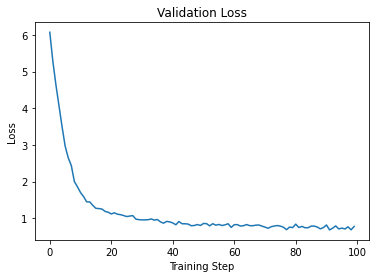

In [172]:
# Visualize loss curve

losses = history.history["val_loss"]
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.show()

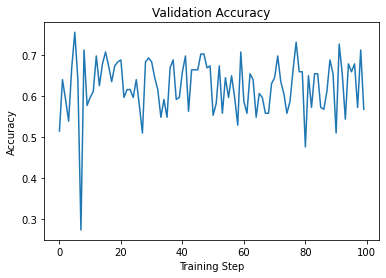

In [173]:
# Visualize accuracy curve

losses = history.history["val_accuracy"]
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.show()

7/7 [==============================] - 0s 4ms/step


/Users/johngalvin/miniforge3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


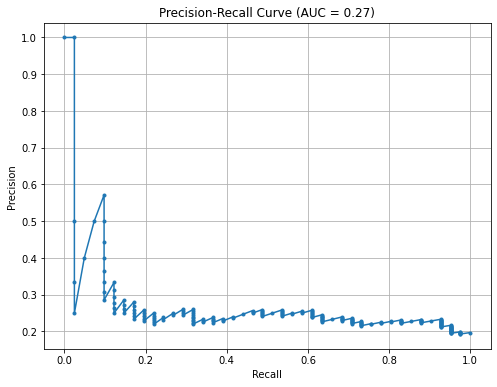

In [174]:
y_scores = model.predict(X_val_final)
precision, recall, thresholds = precision_recall_curve(y_val_final, y_scores)

# Calculate area under the curve (AUC) for the precision-recall curve
auc_score = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(auc_score))
plt.grid(True)
plt.show()

In [179]:
target_precision = 0.2
target_recall = 0.9

idx = np.argmax(np.where((precision >= target_precision) & (recall >= target_recall)))
optimal_threshold = thresholds[idx]

print("Optimal Classification Threshold:", optimal_threshold)

Optimal Classification Threshold: 0.4132321


In [180]:
def custom_predict(model, X, threshold=optimal_threshold):
    probabilities = model.predict(X)  # Get predicted probabilities
    predictions = (probabilities > threshold).astype(int)  # Apply threshold for binary predictions
    return predictions

y_test_predictions = custom_predict(model, X_test_final, threshold=optimal_threshold)

9/9 [==============================] - 0s 3ms/step


/Users/johngalvin/miniforge3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [181]:
accuracy = accuracy_score(y_test_final, y_test_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.3488372093023256


## K-fold Cross Validation

In [99]:
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [100]:
acc_per_fold = []
loss_per_fold = []

In [101]:
fold_no = 1
for train, test in kf.split(X_train_final, y_train_resampled):
    model = create_model()
    
    history = model.fit(X_train_final[train], y_train_resampled[train], epochs=10, batch_size=32, validation_data=(X_train_final[test], y_train_final[test]))
    
    # Generate generalization metrics
    scores = model.evaluate(X_val_final, y_val_final, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no += 1

# Print average metrics
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/10
 7/21 [=========>....................] - ETA: 0s - loss: 6.9733 - accuracy: 0.4107

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/johngalvin/miniforge3/lib/python3.9/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


21/21 [==============================] - 1s 26ms/step - loss: 6.9376 - accuracy: 0.4751 - val_loss: 6.8481 - val_accuracy: 0.6149
Epoch 2/10
21/21 [==============================] - 1s 24ms/step - loss: 6.8630 - accuracy: 0.5530 - val_loss: 6.7845 - val_accuracy: 0.7516
Epoch 3/10
21/21 [==============================] - 1s 25ms/step - loss: 6.8117 - accuracy: 0.5903 - val_loss: 6.7319 - val_accuracy: 0.7640
Epoch 4/10
21/21 [==============================] - 1s 24ms/step - loss: 6.7358 - accuracy: 0.6604 - val_loss: 6.6902 - val_accuracy: 0.7702
Epoch 5/10
21/21 [==============================] - 1s 24ms/step - loss: 6.7028 - accuracy: 0.6651 - val_loss: 6.6557 - val_accuracy: 0.7702
Epoch 6/10
21/21 [==============================] - 1s 24ms/step - loss: 6.6539 - accuracy: 0.7274 - val_loss: 6.6258 - val_accuracy: 0.7702
Epoch 7/10
21/21 [==============================] - 1s 25ms/step - loss: 6.6369 - accuracy: 0.7430 - val_loss: 6.5983 - val_accuracy: 0.7702
Epoch 8/10
21/21 [======

# Try SVC

In [71]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [72]:
# Instantiate Model
svc = SVC()

In [73]:
# Grid search
param_grid = {
    "C": [0.1, 1, 10],                
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto", 0.1],
    "degree": [1, 2, 3, 4, 5]}

In [74]:
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring="accuracy")

In [75]:
# grid_search.fit(X_train_final, y_train_resampled)
grid_search.fit(X_train_final, y_train_final)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [1, 2, 3, 4, 5],
                         'gamma': ['scale', 'auto', 0.1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [76]:
# Get the best parameters and best accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

Best Parameters: {'C': 1, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Accuracy: 0.7746040372670808


In [77]:
# Instantiate and fit model
svc = SVC(C=1, degree=1, gamma=0.1, kernel="rbf")

svc.fit(X_train_final, y_train_final)

SVC(C=1, degree=1, gamma=0.1)

In [78]:
# Assess
y_pred = svc.predict(X_test_final)

# evaluate predictions
print(classification_report(y_test_final, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87       201
           1       0.00      0.00      0.00        57

    accuracy                           0.78       258
   macro avg       0.39      0.50      0.44       258
weighted avg       0.61      0.78      0.68       258



# What if we do image-only?

Note: this model below accepts the pooled embeddings formed after VGG16 feature extraction. The only difference from above is that it does **not** concatenate each final pooled embedding with the clinical/genetic feature vector.

In [46]:
X_train_img_only = np.vstack(X_train_resampled["embedding"])
y_train_img_only = y_train_resampled

X_test_img_only = np.vstack(X_test_scaled["embedding"])
y_test_img_only = y_test_final

In [50]:
def create_model(dropout=0.3, learning_rate=0.0001, l2_penalty=0.01):
    """Builds classification model"""
    
    model = tf.keras.Sequential()
    inputs = tf.keras.layers.Input(shape=(512,), name="input_layer") # (Batch, num_features)
    
    hidden_1 = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_penalty), name="hidden_1")(inputs)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)
    hidden_2 = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_penalty), name="hidden_2")(hidden_1)
    hidden_2 = tf.keras.layers.Dropout(dropout)(hidden_2)
    
    classification = tf.keras.layers.Dense(1, activation="sigmoid", name="classification_layer")(hidden_2)
    classification_model = tf.keras.Model(inputs=[inputs], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                                 metrics="accuracy")

    return classification_model

In [51]:
img_only_model = create_model()

In [52]:
tf.config.run_functions_eagerly(True)
img_only_history = img_only_model.fit(X_train_img_only,
                                      y_train_img_only,
                                      #validation_data=[X_test_img_only, y_test_img_only],
                                      batch_size=16,
                                      epochs=100)

Epoch 1/100
99/99 [==============================] - 3s 28ms/step - loss: 5.2320 - accuracy: 0.4879
Epoch 2/100
99/99 [==============================] - 3s 27ms/step - loss: 4.2243 - accuracy: 0.5044
Epoch 3/100
99/99 [==============================] - 3s 28ms/step - loss: 3.4603 - accuracy: 0.5019
Epoch 4/100
99/99 [==============================] - 3s 28ms/step - loss: 2.8726 - accuracy: 0.5089
Epoch 5/100
99/99 [==============================] - 3s 28ms/step - loss: 2.4191 - accuracy: 0.5222
Epoch 6/100
99/99 [==============================] - 3s 27ms/step - loss: 2.0730 - accuracy: 0.5356
Epoch 7/100
99/99 [==============================] - 3s 28ms/step - loss: 1.8120 - accuracy: 0.5152
Epoch 8/100
99/99 [==============================] - 3s 28ms/step - loss: 1.6087 - accuracy: 0.5267
Epoch 9/100
99/99 [==============================] - 3s 27ms/step - loss: 1.4542 - accuracy: 0.5305
Epoch 10/100
99/99 [==============================] - 3s 28ms/step - loss: 1.3379 - accuracy: 0.5254

In [53]:
img_only_model.evaluate(X_test_img_only, y_test_img_only)

9/9 [==============================] - 0s 14ms/step - loss: 0.7065 - accuracy: 0.5543


[0.706453800201416, 0.5542635917663574]